<a href="https://colab.research.google.com/github/LeonardFreris/fleonardos_ece_uth_projects/blob/main/criminal_vancuver_DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import holidays
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

data = pd.read_csv('/content/drive/MyDrive/new_crime_data.csv')

# Pre-processing

Take a look at the dataset

In [2]:
data.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Break and Enter Commercial,2012,12,14,8,52,NaN,Oakridge,491285.000000,5.453433e+06
1,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490612.964805,5.457110e+06
2,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.779775,5.459174e+06
3,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.943352,5.459166e+06
4,Break and Enter Commercial,2005,11,14,3,9,10XX ALBERNI ST,West End,491021.385727,5.459161e+06


Check how many missing values are in it.

In [3]:
def missing_value_describe(data):
    missing_value_stats = (data.isnull().sum() / len(data)*100)

    missing_value_col_count = sum(missing_value_stats > 0)
    missing_value_stats = missing_value_stats.sort_values(ascending=False)[:missing_value_col_count]

    print("Number of columns with missing values:", missing_value_col_count)
    if missing_value_col_count != 0:
        print("Missing percentage (descending):")
        print(missing_value_stats)

missing_value_describe(data)

Number of columns with missing values: 4
Missing percentage (descending):
NEIGHBOURHOOD    10.409943
X                 0.019230
Y                 0.019230
HUNDRED_BLOCK     0.002083
dtype: float64


Let's take a closer look at entries with "NEIGHBOURHOOD = N/A" and figure out how to reduce the number of it.

In [4]:
data['NEIGHBOURHOOD'].fillna('N/A', inplace = True)
data.loc[(data['NEIGHBOURHOOD']=='N/A')]

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
38807,Break and Enter Commercial,2007,9,23,18,5,X NK_LOC ST,N/A,492757.48676,5.458792e+06
38808,Break and Enter Commercial,2007,11,1,14,38,X NK_LOC ST,N/A,492757.48676,5.458792e+06
38809,Break and Enter Commercial,2005,5,18,18,30,"X NK_LOC ST ""SQUAMISH""",N/A,492757.48676,5.458792e+06
105232,Break and Enter Residential/Other,2004,6,3,14,20,X NK_LOC ST,N/A,492757.48676,5.458792e+06
105233,Break and Enter Residential/Other,2008,3,13,7,0,X NK_LOC ST,N/A,492757.48676,5.458792e+06
...,...,...,...,...,...,...,...,...,...,...
622605,Vehicle Collision or Pedestrian Struck (with I...,2005,4,5,14,14,W 41ST AV / E BOULEVARD,N/A,NaN,NaN
622606,Vehicle Collision or Pedestrian Struck (with I...,2005,2,21,13,15,W 41ST AV / W BLVD,N/A,NaN,NaN
623275,Vehicle Collision or Pedestrian Struck (with I...,2003,2,5,23,17,W BOULEVARD / W 41ST AV,N/A,NaN,NaN
623786,Vehicle Collision or Pedestrian Struck (with I...,2003,4,30,13,12,WEST 71ST AV/HUDSON ST,N/A,NaN,NaN


Since X and Y coordinations are zero, we can not include these entries into a neighbourhood. So they will be useless in our visualization and we should get rid of them.

So we are trying to predict whether crime will occur given a when and where, we should have "No Crime" included in our dataset as well. Otherwise, our model will assume crime always occurs.

In [5]:
data = data.sort_values(['YEAR', 'MONTH', 'DAY', 'HOUR', 'NEIGHBOURHOOD']).reset_index(drop = True)

def range_date(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

neighbourhoods = data['NEIGHBOURHOOD'].unique()
neighbourhoods = np.delete(neighbourhoods, np.where(neighbourhoods == 'N/A'), axis=0)

data_append_list = []

for date_ in range_date(date(data.head(1)['YEAR'], data.head(1)['MONTH'], data.head(1)['DAY']), date(data.tail(1)['YEAR'], data.tail(1)['MONTH'], data.tail(1)['DAY']) + timedelta(days = 1)):
    for hour_ in range(0, 24):
        data_ = data.loc[(data['YEAR'] == date_.year) & (data['MONTH'] == date_.month) & (data['DAY'] == date_.day) & (data['HOUR'] == hour_)]
        
        neighbourhoods_ = data_['NEIGHBOURHOOD'].unique()
        neighbourhoods_ = np.delete(neighbourhoods_, np.where(neighbourhoods_ == 'N/A'), axis=0)
        
        data_append_list_ = [{"TYPE": 'No Crime', "YEAR": date_.year, "MONTH": date_.month, "DAY": date_.day, "HOUR": hour_, "MINUTE": 0, "HUNDRED_BLOCK": 'N/A', "NEIGHBOURHOOD": i, "X": 0, "Y": 0} for i in set(neighbourhoods) - (set(neighbourhoods_))]
        data_append_list.extend(data_append_list_)

data = data.append(pd.DataFrame.from_dict(data_append_list))

After the dataset is updated, let's add some additional columns that could be useful during the analysis. We start by categorizing the column "TYPE".

In [6]:
data['TYPE'].unique()

def categorize(x):
    if 'No Crime' in x:
        return 'No Crime'
    elif 'Theft' in x:
        return 'Theft'
    elif 'Break' in x:
        return 'Break and Enter'
    elif 'Collision' in x:
        return 'Vehicle Collision'
    else:
        return 'Others'

data['CATEGORY'] = data.apply(lambda x : categorize(x.TYPE), axis = 1)

Next, we format the columns "YEAR", "MONTH" and "DAY" into datetime.The result is placed into the column "DATETIME".

We also check the datetime to see what day the reported crime activity occured.
The result is placed into the column "WEEKDAY".

In [7]:
data['DATETIME'] = pd.to_datetime({'year': data['YEAR'], 'month': data['MONTH'], 'day': data['DAY']})
data['WEEKDAY'] = data['DATETIME'].dt.day_name()

We will create two new columns "ISHOLIDAY" and "ISOFFDAY" to check if a date is an off-day. 



In [24]:
def isholiday(x, y, z):
    return date(x, y, z) in ca_holidays

ca_holidays = holidays.CountryHoliday('CA', prov='BC', state=None)
data['ISHOLIDAY'] = data.apply(lambda x : isholiday(x.YEAR, x.MONTH, x.DAY), axis = 1)

def isoffday(x, y):
    return x == "Sunday" or x == "Saturday" or y

data['ISOFFDAY'] = data.apply(lambda x : isoffday(x.WEEKDAY, x.ISHOLIDAY), axis = 1)

In [9]:
data.head(500)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,CATEGORY,DATETIME,WEEKDAY,ISHOLIDAY,ISOFFDAY
0,Mischief,2003,1,1,0,30,9XX CANADA PL,Central Business District,491613.020705,5.459491e+06,Others,2003-01-01,Wednesday,True,True
1,Theft from Vehicle,2003,1,1,0,0,11XX HOWE ST,Central Business District,490849.968896,5.458443e+06,Theft,2003-01-01,Wednesday,True,True
2,Theft from Vehicle,2003,1,1,0,0,2XX DRAKE ST,Central Business District,490968.942903,5.457901e+06,Theft,2003-01-01,Wednesday,True,True
3,Theft from Vehicle,2003,1,1,0,30,4XX ABBOTT ST,Central Business District,492183.961060,5.458755e+06,Theft,2003-01-01,Wednesday,True,True
4,Theft of Bicycle,2003,1,1,0,5,11XX HORNBY ST,Central Business District,490705.343968,5.458446e+06,Theft,2003-01-01,Wednesday,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Break and Enter Residential/Other,2003,1,3,22,0,12XX PACIFIC ST,West End,489988.513834,5.458640e+06,Break and Enter,2003-01-03,Friday,False,False
496,Theft from Vehicle,2003,1,3,22,45,14XX DAVIE ST,West End,490079.703279,5.459005e+06,Theft,2003-01-03,Friday,False,False
497,Theft from Vehicle,2003,1,3,23,0,21XX W 37TH AVE,Arbutus Ridge,488488.628521,5.453968e+06,Theft,2003-01-03,Friday,False,False
498,Mischief,2003,1,3,23,30,DRAKE ST / RICHARDS ST,Central Business District,490847.272016,5.458015e+06,Others,2003-01-03,Friday,False,False


In [10]:
p = open('data', 'wb')
pickle.dump(data, p)
p.close()

# Visualization

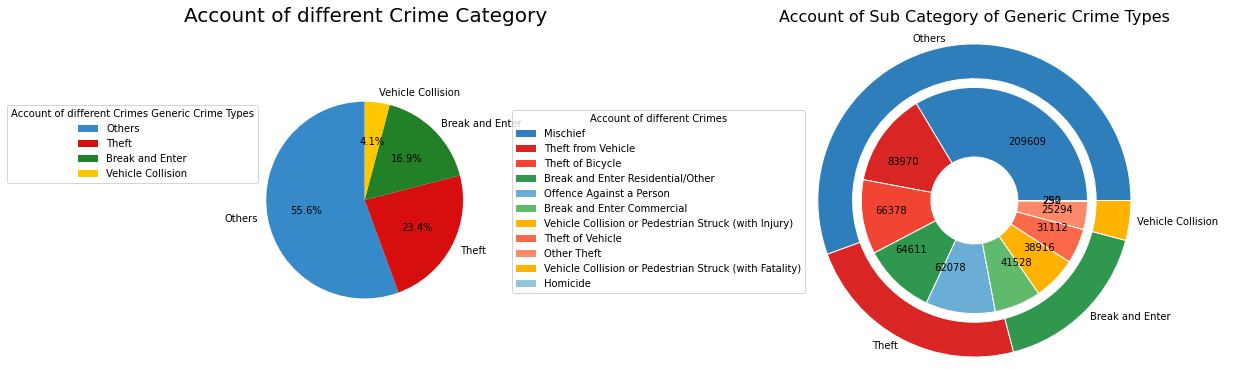

In [11]:
fig = plt.figure(figsize=(20,4))
data = data.query('TYPE != "No Crime"')

#Visualization - Account of different Crimes Generic Crime Types
ax1 = fig.add_subplot(1,2,1)
crime_categorycount = data['CATEGORY'].value_counts().tolist()
crime_category = data['CATEGORY'].unique().tolist()
colors = ["#368ac9", "#d60e0e", "#228027", "#ffc700"]
ax1.pie(crime_categorycount, colors=colors,labels=crime_category, startangle=90, autopct='%.1f%%')
ax1.axis('equal')
ax1.legend(crime_category ,title="Account of different Crimes Generic Crime Types", bbox_to_anchor=(.23,0.7),loc='right', bbox_transform=plt.gcf().transFigure)
ax1.set_title('Account of different Crime Category', pad=70,fontsize=20)

#Visualization - Account of Sub Category of Generic Crime Types
ax2 = fig.add_subplot(1,2,2)
group_names = data['CATEGORY'].unique().tolist()
group_size=data['CATEGORY'].value_counts().tolist()
subgroup=data['TYPE'].unique().tolist()
subgroup_names=data['TYPE'].value_counts().tolist()
subgroup_size=data['TYPE'].value_counts().tolist()
# Create colors
a, b, c , d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.autumn]

# Second Ring (Inside)
mypie2, _ = ax2.pie(subgroup_size, radius=1.3, labels=subgroup_names, labeldistance=.6, colors=[a(0.7), b(0.7), b(0.6),c(0.7),a(0.5),c(0.55), d(0.7), b(0.5),b(0.4),d(0.7),a(0.4)])
ax2.legend(subgroup ,title="Account of different Crimes", bbox_to_anchor=(.61,0.5),loc='right', bbox_transform=plt.gcf().transFigure)
ax2.set_title('Account of Sub Category of Generic Crime Types', pad=70,fontsize=16)
plt.setp( mypie2, width=0.8, edgecolor='white')

# First Ring (outside)
ax2.axis('equal')
mypie, _ = ax2.pie(group_size, radius=1.8, labels=group_names,labeldistance=1.05, colors=[a(0.7), b(0.7), c(0.7), d(0.7)] )
plt.setp( mypie, width=0.4, edgecolor='white')

plt.margins(0,0)
plt.show()

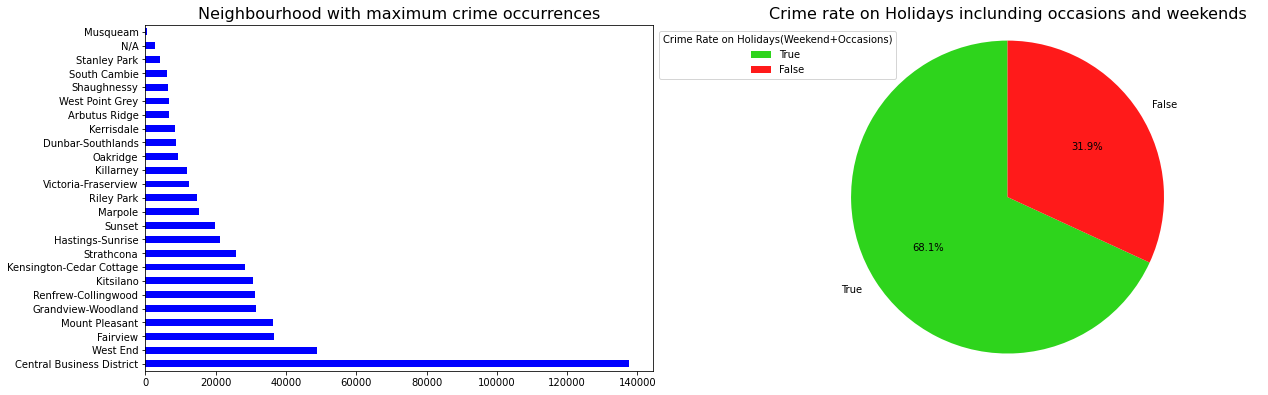

In [12]:
plt.figure(figsize=(20,14))
#Plot 1
plt.subplot(2,2,1)
data = data[data['HUNDRED_BLOCK'] != 'OFFSET TO PROTECT PRIVACY']
data['NEIGHBOURHOOD'].value_counts().plot.barh(color="blue")
plt.title("Neighbourhood with maximum crime occurrences",fontsize=16)
#Plot 2
ax1 = plt.subplot(2,2,2)
Holidaycount = data['ISOFFDAY'].value_counts().tolist()
HolidayTorF = data['ISOFFDAY'].unique().tolist()
colors = ["#2ed41c", "#ff1a1a"]
ax1.pie(Holidaycount, colors=colors,labels=HolidayTorF, startangle=90, autopct='%.1f%%')
ax1.axis('equal')
ax1.legend(HolidayTorF ,title="Crime Rate on Holidays(Weekend+Occasions)", bbox_to_anchor=(.65,0.85),loc='right', bbox_transform=plt.gcf().transFigure)
plt.title("Crime rate on Holidays inclunding occasions and weekends",fontsize=16)
plt.show()

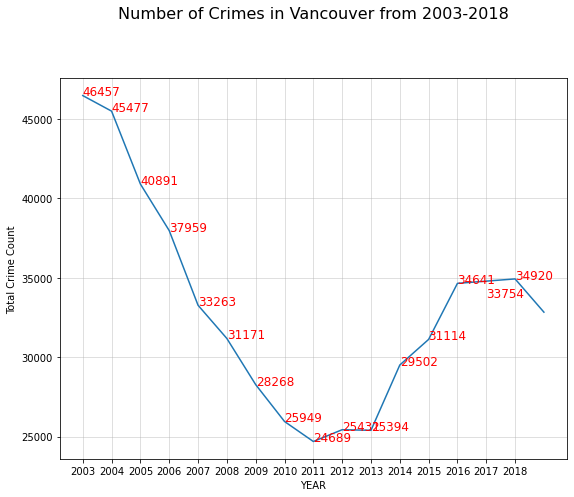

In [13]:
fig = plt.figure(figsize=(20,7))
#Visualization - Number of Crimes in Vancouver from 2003-2018
ax1 = fig.add_subplot(1,2,1)
ax = pd.value_counts(data[data.YEAR != 2017]['YEAR']).sort_index().plot(ax=ax1)
ax.set_title('Number of Crimes in Vancouver from 2003-2018', pad=60,fontsize=16)
ticks=data[data.YEAR != 2019]['YEAR'].unique()
ax.set_xticks(ticks)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
ax.set_ylabel('Total Crime Count')
ax.set_xlabel('YEAR')
for i,j in pd.value_counts(data[data.YEAR != 2019]['YEAR']).sort_index().items():
    ax.annotate(str(j), xy=(i, j),color="red",fontsize=12)

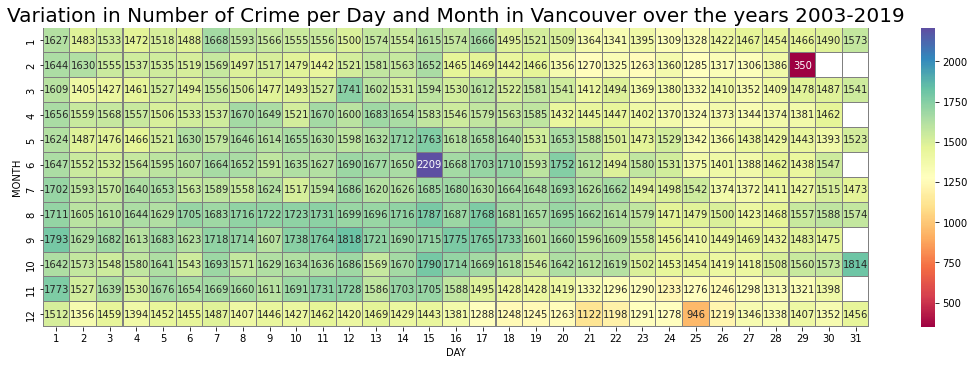

In [14]:
#Visualization - Average Number of Crime per DAY and Month
plt.figure(figsize=(18.5,5.5))
chron=pd.DataFrame(data.groupby(['DAY','MONTH']).count()).reset_index().rename(columns={'TYPE':'Total Crime'})[['MONTH','DAY','Total Crime']]
chron=chron.pivot('MONTH','DAY','Total Crime')
plt.title('Variation in Number of Crime per Day and Month in Vancouver over the years 2003-2019', fontsize=20)
sns.heatmap(chron,annot=True,fmt='g', cmap='Spectral',linecolor='grey',linewidths=0.06)

Text(0.5, 1.0, 'Variation of Crime over different week days')

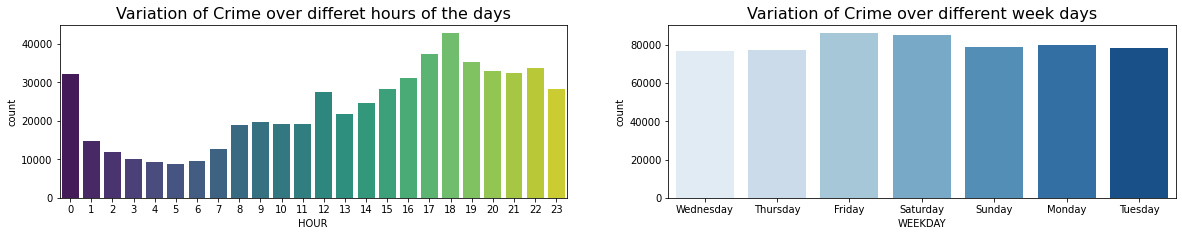

In [15]:
plt.figure(figsize=(20,7))
#Plot 1
plt.subplot(2,2,1)
sns.countplot(x='HOUR', data=data,palette='viridis')
plt.title("Variation of Crime over differet hours of the days",fontsize=16)
#Plot 2
plt.subplot(2,2,2)
sns.countplot(x='WEEKDAY', data=data,palette='Blues')
plt.title("Variation of Crime over different week days",fontsize=16)

# Modeling

In [16]:
p = open('data', 'rb')
data = pickle.load(p)
p.close()

In [17]:
data = data.query('NEIGHBOURHOOD != "N/A"')

we need to select features we will be using during the modeling and analysis.

In [18]:
feature_cols = ['MONTH', 'DAY', 'HOUR', 'NEIGHBOURHOOD', 'ISOFFDAY']

data_X = data[feature_cols]
data_Y = data['TYPE']

Since columns "TYPE", "NEIGHBOURHOOD" and "ISOFFDAY" are non-numerical values, we need to convert them into numbers.

In [19]:
le_neighbourhood = preprocessing.LabelEncoder().fit(data_X['NEIGHBOURHOOD'])
#le_neighbourhood.fit(data_X['NEIGHBOURHOOD'])

data_X['NEIGHBOURHOOD'] = le_neighbourhood.transform(data_X['NEIGHBOURHOOD'])

le_isoffday = preprocessing.LabelEncoder().fit(data_X['ISOFFDAY'])
#le_isoffday.fit(data_X['ISOFFDAY'])

data_X['ISOFFDAY'] = le_isoffday.transform(data_X['ISOFFDAY'])

le_type = preprocessing.LabelEncoder().fit(data_Y)
#le_type.fit(data_Y)

data_Y = le_type.transform(data_Y)

Next, we split our dataset into a training set and a testing set. 

In [20]:
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size = 0.25, random_state = 0)

Finally, we apply the classifiers.

Let's start with the decision tree classifier using default parameters first.

In [21]:
model_decisiontree = DecisionTreeClassifier(criterion="entropy").fit(train_X, train_Y)
#model_decisiontree = model_decisiontree.fit(train_X, train_Y)

pred_Y = model_decisiontree.predict(test_X)

print("Accuracy:", metrics.accuracy_score(test_Y, pred_Y))

Accuracy: 0.8390792429107466


Next, let's try out the K-Nearest Neighbour classifier using default parameters as well.

In [22]:
classifier = KNeighborsClassifier(n_neighbors = 5).fit(train_X, train_Y)
#classifier.fit(train_X, train_Y)
y_pred = classifier.predict(test_X)
print("Accuracy:", metrics.accuracy_score(test_Y, y_pred))

Accuracy: 0.8400222211065587


As you can see, we can achieve around 84% accuracy with both the decision tree classifier and the K-Nearest Neighbour  classifier.

Now let's check out.

In [23]:
my_day = pd.DataFrame()
my_day["MONTH"] = [6]
my_day["DAY"] = [15]
my_day["HOUR"] = [18]
my_day["NEIGHBOURHOOD"] = [ "West End" ]
my_day["ISOFFDAY"] = [ False ]

my_day['NEIGHBOURHOOD'] = le_neighbourhood.transform(my_day['NEIGHBOURHOOD'])
my_day['ISOFFDAY'] = le_isoffday.transform(my_day['ISOFFDAY'])

pred_my_day = model_decisiontree.predict(my_day)

if pred_my_day ==3:
    print("Safe")
else:
    print("Not safe")

Safe
